# Cuatro en Raya

!["Entorno"](https://www.casualarena.com/bundles/app/st/games/co4/rules/connect-4-rules.jpg?8877992)

# Iteración de Política

Este algoritmo encuentra la política óptima y su función de valor alternando dos procesos iterativamente

![](https://www.researchgate.net/profile/Henry-Diaz-Iza/publication/322092684/figure/fig3/AS:631644897673244@1527607287617/Figura-2-4-Iteracion-de-la-politica-generalizada-GPI4.png)

# Setup code

Funciones de utilidad

In [419]:
!pip install -qq gym==0.23.0

import numpy as np
import gym
from gym import spaces
import pygame
from pygame import gfxdraw
from typing import Tuple, Dict, Optional
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import seaborn as sns

# Clase Connect4Env
class Connect4Env(gym.Env):
    metadata = {'render.modes': ['human', 'rgb_array']}

    def __init__(self, shaped_rewards: bool = False) -> None:
        super().__init__()
        self.shaped_rewards = shaped_rewards
        self.ROW_COUNT = 6
        self.COLUMN_COUNT = 7
        self.action_space = spaces.Discrete(self.COLUMN_COUNT)
        self.observation_space = spaces.MultiDiscrete([self.ROW_COUNT, self.COLUMN_COUNT])
        self.board = self.create_board()
        self.done = False
        self.current_player = 1
        self.screen = None
        self.clock = None
        self.reset()

    def create_board(self):
        return np.zeros((self.ROW_COUNT, self.COLUMN_COUNT))

    def drop_piece(self, row, col, piece):
        self.board[row][col] = piece

    def is_valid_location(self, col):
        return self.board[self.ROW_COUNT-1][col] == 0

    def get_next_open_row(self, col):
        for r in range(self.ROW_COUNT):
            if self.board[r][col] == 0:
                return r

    def winning_move(self, piece):
        for c in range(self.COLUMN_COUNT-3):
            for r in range(self.ROW_COUNT):
                if self.board[r][c] == piece and self.board[r][c+1] == piece and self.board[r][c+2] == piece and self.board[r][c+3] == piece:
                    return True
        for c in range(self.COLUMN_COUNT):
            for r in range(self.ROW_COUNT-3):
                if self.board[r][c] == piece and self.board[r+1][c] == piece and self.board[r+2][c] == piece and self.board[r+3][c] == piece:
                    return True
        for c in range(self.COLUMN_COUNT-3):
            for r in range(self.ROW_COUNT-3):
                if self.board[r][c] == piece and self.board[r+1][c+1] == piece and self.board[r+2][c+2] == piece and self.board[r+3][c+3] == piece:
                    return True
        for c in range(self.COLUMN_COUNT-3):
            for r in range(3, self.ROW_COUNT):
                if self.board[r][c] == piece and self.board[r-1][c+1] == piece and self.board[r-2][c+2] == piece and self.board[r-3][c+3] == piece:
                    return True
        return False


    def step(self, action: int) -> Tuple[np.ndarray, float, bool, Dict]:
        if not self.is_valid_location(action):
            return self.board, -10, True, {}

        row = self.get_next_open_row(action)
        self.drop_piece(row, action, self.current_player)

        if self.winning_move(self.current_player):
            reward = 1
            self.done = True
        elif np.all(self.board != 0):
            reward = 0
            self.done = True
        else:
            reward = 0
            self.current_player = 3 - self.current_player  # Alternates between 1 and 2

        return self.board, reward, self.done, {}

    def reset(self) -> np.ndarray:
        self.board = self.create_board()
        self.done = False
        self.current_player = 1
        return self.board

    def render(self, mode: str = 'human') -> Optional[np.ndarray]:
        assert mode in ['human', 'rgb_array']

        SQUARESIZE = 100
        RADIUS = int(SQUARESIZE/2 - 5)
        width = self.COLUMN_COUNT * SQUARESIZE
        height = (self.ROW_COUNT+1) * SQUARESIZE
        size = (width, height)

        if self.screen is None:
            pygame.init()
            self.screen = pygame.display.set_mode(size)
            self.clock = pygame.time.Clock()

        for c in range(self.COLUMN_COUNT):
            for r in range(self.ROW_COUNT):
                pygame.draw.rect(self.screen, (0, 0, 255), (c*SQUARESIZE, r*SQUARESIZE+SQUARESIZE, SQUARESIZE, SQUARESIZE))
                pygame.draw.circle(self.screen, (0, 0, 0), (int(c*SQUARESIZE+SQUARESIZE/2), int(r*SQUARESIZE+SQUARESIZE+SQUARESIZE/2)), RADIUS)

        for c in range(self.COLUMN_COUNT):
            for r in range(self.ROW_COUNT):
                if self.board[r][c] == 1:
                    pygame.draw.circle(self.screen, (255, 0, 0), (int(c*SQUARESIZE+SQUARESIZE/2), height-int(r*SQUARESIZE+SQUARESIZE/2)), RADIUS)
                elif self.board[r][c] == 2:
                    pygame.draw.circle(self.screen, (255, 255, 0), (int(c*SQUARESIZE+SQUARESIZE/2), height-int(r*SQUARESIZE+SQUARESIZE/2)), RADIUS)

        if mode == 'human':
            pygame.display.update()
        elif mode == 'rgb_array':
            return np.transpose(np.array(pygame.surfarray.pixels3d(self.screen)), axes=(1, 0, 2))

    def close(self) -> None:
        if self.screen is not None:
            pygame.display.quit()
            pygame.quit()
            self.screen = None

    def compute_reward(self, state: np.ndarray, action: int) -> float:
        next_state = self._get_next_state(state, action)
        if self.shaped_rewards:
            reward = 0
            # Recompensa por formar una línea de 2 piezas propias
            if self.check_line(next_state, 2, self.current_player):
                reward += 0.1
            # Recompensa por formar una línea de 3 piezas propias
            if self.check_line(next_state, 3, self.current_player):
                reward += 0.3
            # Penalización por permitir que el oponente forme una línea de 2 piezas
            if self.check_line(next_state, 2, 3 - self.current_player):
                reward -= 0.1
            # Penalización por permitir que el oponente forme una línea de 3 piezas
            if self.check_line(next_state, 3, 3 - self.current_player):
                reward -= 0.3
            return reward
        return - float(self.done)

    def check_line(self, state, length, player):
        # Verificar líneas de longitud dada para el jugador
        for c in range(self.COLUMN_COUNT - length + 1):
            for r in range(self.ROW_COUNT):
                if all(state[r, c + i] == player for i in range(length)):
                    return True
        for c in range(self.COLUMN_COUNT):
            for r in range(self.ROW_COUNT - length + 1):
                if all(state[r + i, c] == player for i in range(length)):
                    return True
        for c in range(self.COLUMN_COUNT - length + 1):
            for r in range(self.ROW_COUNT - length + 1):
                if all(state[r + i, c + i] == player for i in range(length)):
                    return True
        for c in range(self.COLUMN_COUNT - length + 1):
            for r in range(length - 1, self.ROW_COUNT):
                if all(state[r - i, c + i] == player for i in range(length)):
                    return True
        return False

    def simulate_step(self, state: Tuple[int, int], action: int) -> Tuple[np.ndarray, float, bool, Dict]:
        next_state = self.board.copy()
        if self.is_valid_location(action):
            row = self.get_next_open_row(action)
            next_state[row, action] = self.current_player
            reward = self.compute_reward(next_state, action)
            done = self.winning_move(self.current_player) or np.all(next_state != 0)
            return next_state, reward, done, {}
        return state, -10, True, {}

    def _get_next_state(self, state: np.ndarray, action: int) -> np.ndarray:
        next_state = np.copy(state)
        if self.is_valid_location(action):
            row = self.get_next_open_row(action)
            next_state[row][action] = self.current_player
        return next_state

def display_video(frames):
    orig_backend = matplotlib.get_backend()
    matplotlib.use('Agg')
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    matplotlib.use(orig_backend)
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.set_position([0, 0, 1, 1])
    im = ax.imshow(frames[0])

    def update(frame):
        im.set_data(frame)
        return [im]

    anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                    interval=50, blit=True, repeat=False)
    return HTML(anim.to_html5_video())

def plot_policy(probs_or_qvals, frame, action_meanings=None):
    if action_meanings is None:
        action_meanings = {i: str(i) for i in range(probs_or_qvals.shape[-1])}
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    max_prob_actions = probs_or_qvals.argmax(axis=-1)
    probs_copy = max_prob_actions.copy().astype(object)
    for key in action_meanings:
        probs_copy[probs_copy == key] = action_meanings[key]
    sns.heatmap(max_prob_actions, annot=probs_copy, fmt='', cbar=False, cmap='coolwarm',
                annot_kws={'weight': 'bold', 'size': 12}, linewidths=2, ax=axes[0])
    axes[1].imshow(frame)
    axes[0].axis('off')
    axes[1].axis('off')
    plt.suptitle("Policy", size=18)
    plt.tight_layout()

def plot_values(state_values, frame):
    f, axes = plt.subplots(1, 2, figsize=(10, 4))
    sns.heatmap(state_values, annot=True, fmt=".2f", cmap='coolwarm',
                annot_kws={'weight': 'bold', 'size': 12}, linewidths=2, ax=axes[0])
    axes[1].imshow(frame)
    axes[0].axis('off')
    axes[1].axis('off')
    plt.tight_layout()


def test_agent(environment, policy, episodes=10):
    frames = []
    for episode in range(episodes):
        state = environment.reset()
        done = False
        frames.append(environment.render(mode="rgb_array"))

        while not done:
            p = policy(state)
            if isinstance(p, np.ndarray):
                action = np.random.choice(environment.action_space.n, p=p)
            else:
                action = p
            next_state, reward, done, extra_info = environment.step(action)
            img = environment.render(mode="rgb_array")
            frames.append(img)
            state = next_state

    return display_video(frames)

# Inicializamos el entorno y lo colocamos en una variable Env

In [420]:
env = Connect4Env()

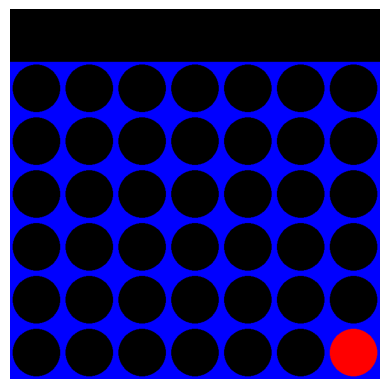

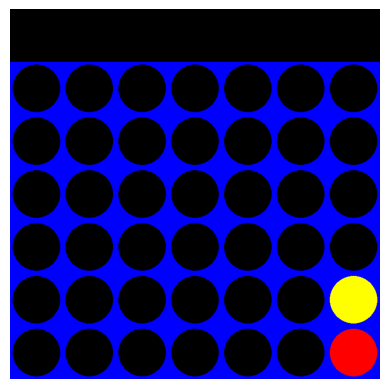

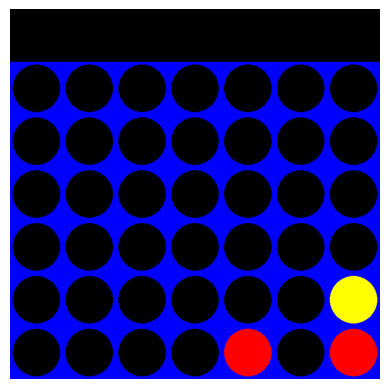

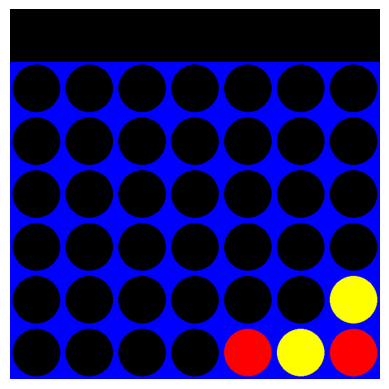

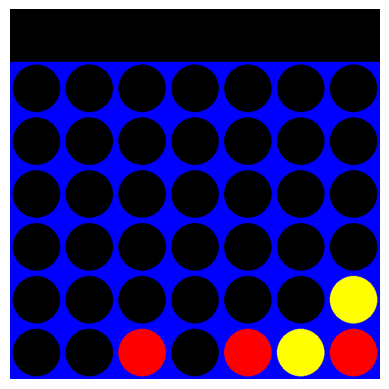

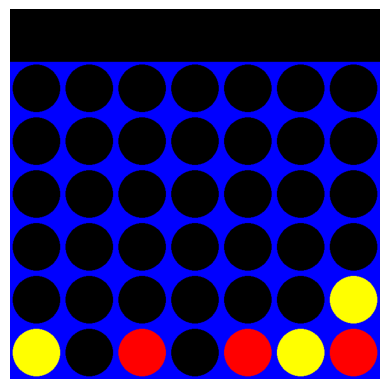

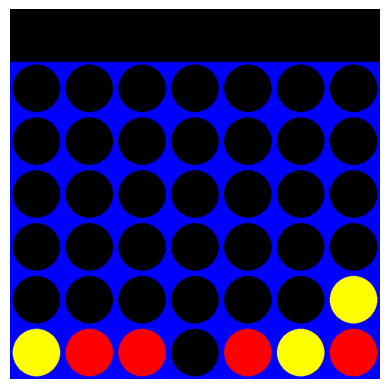

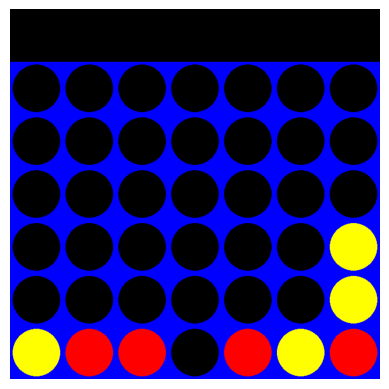

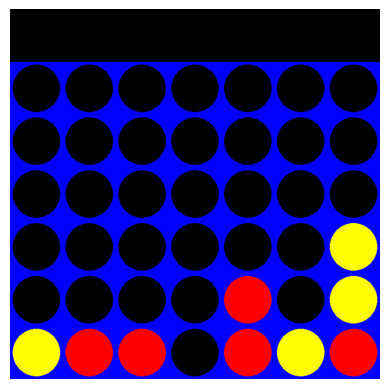

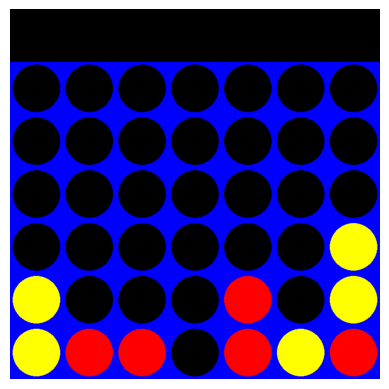

In [421]:
# Realizamos una serie de pasos aleatorios en el entorno
for _ in range(10):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    frame = env.render(mode='rgb_array')
    plt.imshow(frame)
    plt.axis('off')
    plt.show()
    if done:
        print("Game Over")
        break

env.close()

Tamaño del espacio de acciones y espacio de estados

In [422]:
print(f"Observation space shape: {env.observation_space.nvec}")
print(f"Number of actions: {env.action_space.n}")

Observation space shape: [6 7]
Number of actions: 7


In [423]:
env.reset()

array([[0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.]])

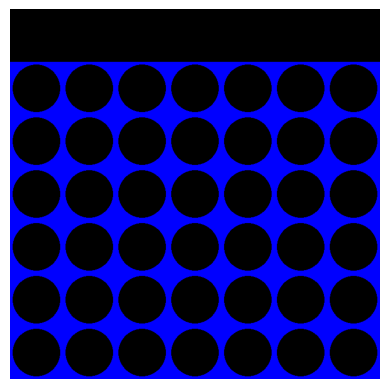

In [424]:
frame = env.render(mode='rgb_array')
plt.axis('off')
plt.imshow(frame)

## Definir la política de toma de decisiones $\pi(\cdot|s)$

#### Creamos la política $\pi(\cdot|s)$

Creamos una tabla de 6x7 en la que cada entrada sea una vector de probabilidades de 7 elementos. Cada uno de esos 7 elementos será la probabilidad de tomar la acción 0, 1,...,6

In [425]:
policy_probs = np.full((6, 7, 7), 1/7)

Al principio esa probabilidad será la misma para todas las acciones

In [426]:
# Política aleatoria

# policy_probs[0, 0] devuelve una matriz de probabilidades uniformes, entonces cada acción tiene la misma
# posibilidad de ser seleccionada

def policy(state):
  return policy_probs[0, 0]

#### Prueba de la política en el estado inicial (0, 0)

In [427]:
action_probabilities = policy((0,0))
for action, prob in zip(range(7), action_probabilities):
    print(f"Probabilidad de tomar la acción {action}: {prob}")

Probabilidad de tomar la acción 0: 0.14285714285714285
Probabilidad de tomar la acción 1: 0.14285714285714285
Probabilidad de tomar la acción 2: 0.14285714285714285
Probabilidad de tomar la acción 3: 0.14285714285714285
Probabilidad de tomar la acción 4: 0.14285714285714285
Probabilidad de tomar la acción 5: 0.14285714285714285
Probabilidad de tomar la acción 6: 0.14285714285714285


#### Test donde un agente que toma una política de decisiones aleatoria se enfrenta al entorno

In [428]:
test_agent(env, policy, episodes=1)

#### Graficamos la política

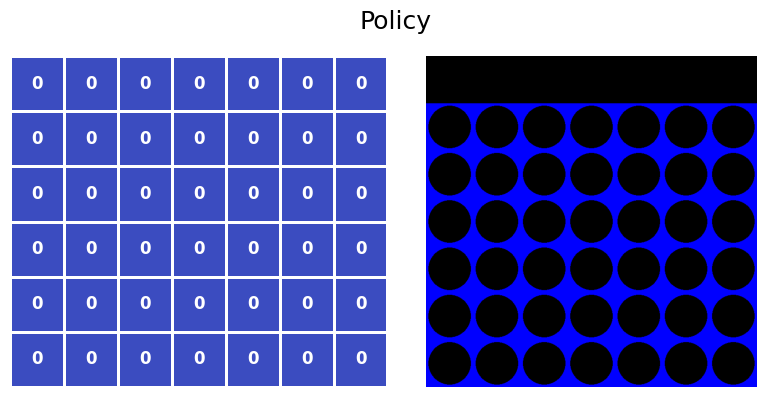

In [429]:
plot_policy(policy_probs, frame)

## Definiendo la tabla de valores $V(s)$

#### Create the $V(s)$ table

In [430]:
state_values = np.zeros(shape=(6,7))

#### Graficando la tabla de valores $V(s)$

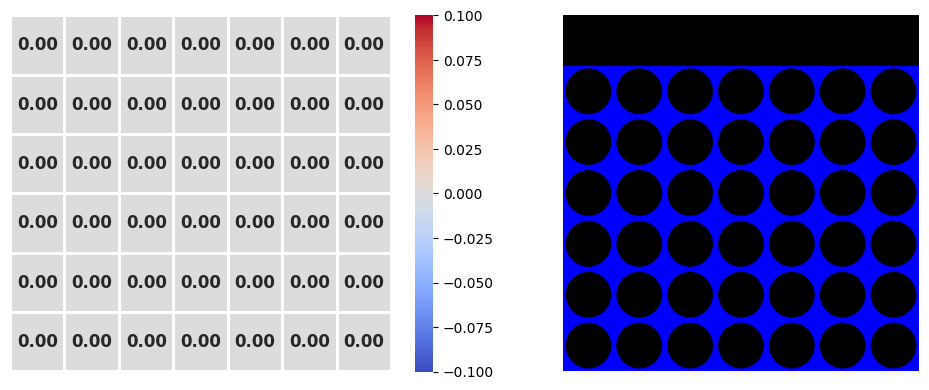

In [431]:
plot_values(state_values, frame)

## Implementando el algoritmo iteración de política

In [432]:
def policy_evaluation(policy_probs, state_values, theta=1e-6, gamma=0.99):
    delta = float("inf")

    while delta > theta:
        delta = 0

        for row in range(7):
            for col in range(6):
                old_value = state_values[(row, col)]
                new_value = 0
                action_probabilities = policy_probs[(row, col)]

                for action, prob in enumerate(action_probabilities):
                    next_state, reward, _, _ = env.simulate_step((row, col), action)
                    new_value += prob * (reward + gamma * state_values[next_state])

                state_values[(row, col)] = new_value

                delta = max(delta, abs(old_value - new_value))

In [433]:
def policy_improvement(policy_probs, state_values, gamma=0.99):

    policy_stable = True
    for row in range(7):
        for col in range(6):
            old_action = policy_probs[(row, col)].argmax()

            new_action = None
            max_qsa = float("-inf")

            for action in range(4):
                next_state, reward, _, _ = env.simulate_step((row, col), action)
                qsa = reward + gamma * state_values[next_state]
                if qsa > max_qsa:
                    max_qsa = qsa
                    new_action = action

            action_probs = np.zeros(4)
            action_probs[new_action] = 1.
            policy_probs[(row, col)] = action_probs

            if new_action != old_action:
                policy_stable = False

    return policy_stable

In [434]:
def policy_iteration(policy_probs, state_values, theta=1e-6, gamma=0.99):
    policy_stable = False

    while not policy_stable:

        policy_evaluation(policy_probs, state_values, theta, gamma)

        policy_stable = policy_improvement(policy_probs, state_values, gamma)

In [435]:
policy_iteration(policy_probs, state_values)

IndexError: arrays used as indices must be of integer (or boolean) type

## Resultados

Tabla de valores V(s)

In [ ]:
plot_values(state_values, frame)

Política resultante $\pi(\cdot|s)$

In [ ]:
plot_policy(policy_probs, frame)

#### Probando el agente con la nueva política

In [ ]:
test_agent(env, policy)

## Recurso

[[1] Reinforcement Learning: An Introduction. Ch. 4: Dynamic Programming](https://web.stanford.edu/class/psych209/Readings/SuttonBartoIPRLBook2ndEd.pdf)